In [3]:
import numpy as np
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp

In [4]:
from casadi import *
from torch import nn
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F



In [5]:
class AAC:
    def __init__(self, m, c_d, f0, f1, f2, v_ego):
        self.m = m
        self.c_d = c_d
        self.f0 = f0
        self.f1 = f1
        self.f2 = f2
        self.v_ego = v_ego
        self.u = 0
        
        
    def update(self, x0, u, t, dt):
        
        x = MX.sym('x',3) # Three states
        
        p = x[0]
        v = x[1]
        z = x[2]
        
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        f = vertcat(
            v,
            -1/self.m*Fr,
            self.v_ego - v           
        )
        g = vertcat([
            0,
            1/self.m *u,
            0
        ])
        

        dx = f + g
        
        ode = {}         # ODE declaration
        ode['x']   = x   # states
        ode['ode'] = dx # right-hand side 

        # Construct a Function that integrates over 4s
        F = integrator('F','cvodes',ode,{'t0':t,'tf':t+dt})

        res = F(x0=x0)
        
        x_n = res['xf'].elements()
        
        return x_n 
        
        

In [6]:
class LQPCBFCLF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_ego_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_ego = v_ego_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
        
    def clf(self, symb_x):
        v = symb_x[1]        

        clf = (v - self.v_des)**2;
        return clf
        
    def cbf(self, symb_x):
        v = symb_x[1]
        z = symb_x[2]

        cbf = z - self.Th * v - 0.5  * (self.v_ego - v)**2 / (self.cd * 9.81);
        return cbf
        

    def dcbf(self, x, u):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2

        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        return dB
        
    def compute_controller(self, x, u_ref, A_h, B_h, weights):
        v = x[1]
        z = x[2]

        u = SX.sym('u')
        slack = SX.sym('slack')
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        V = self.clf(x)
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))

        B = self.cbf(x);
        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        S = dB + A_h.forward(x) + B_h.forward(x) * u
        
        weight_input = 2/self.m**2
        
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, S + self.cbf_rate * B)
        
        # Optimization
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        
        S = qpsol('S', 'qpoases', qp,{'verbose':False,'print_time':False})
             
        r = S(lbg=0) # lbx = -5000, ubx = 5000
        
        k = r['x'].elements()[0]
        slack_sol = r['x'].elements()[1]
        
        return k, slack_sol, V, B, dB

In [7]:
from collections import deque, namedtuple
import random
import torch

Transition = namedtuple('Transition',
                        ('x', 'k', 'dh', 'dh_hat'))


class Dataset:
    def __init__(self):
        #self.capacity = capacity 
        self.D = deque()
        
    def reset(self):
        self.D = deque()
    
    def update(self, *args):
        self.D.append(Transition(*args))
        
    def get_D(self):
        sample = Transition(*zip(*self.D))
        return sample
        
    

In [8]:
def sample_initial_state(p_min = 0, p_max = 1,
                         v_min = 0, v_max = 10,
                         z_min = 20, z_max = 30):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return [p0, v0, z0]

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        return dx
    

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)

class Estimator:
    def __init__(self, input_size, output_size = 1):
        f1 = 50
        f2 = 50
        
        self.model = nn.Sequential(
                                  nn.Linear(input_size, f1),                   nn.Sigmoid(),
                                  nn.Linear(f1, f2),                           nn.Sigmoid(),
                                  nn.Linear(f2, output_size)
                                )
        
        self.model.apply(weights_init)
        
    def forward(self, x, train = False):
        x = torch.from_numpy(np.array(x)).float()
        #print(x)
        z = self.model(x)
        
        if not train:
            z = z.detach().float().item()
            
        return z

In [10]:
dt = 0.02
simTime = 1

# Real parameters
v_ego = 14
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 0.01
f1_nom = 0.01
f2_nom = 0.01

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 100

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


In [11]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

A_h = Estimator(3)
A_h_opt = torch.optim.Adam(A_h.model.parameters(), lr = 1e-4)

B_h = Estimator(3)
B_h_opt = torch.optim.Adam(B_h.model.parameters(), lr = 1e-4)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []

for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    slacks = []
    
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)
        
        if k< -5000:
            k = -5000
        elif k > 5000:
            k = 5000

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)
        
        A_h.model.zero_grad()
        B_h.model.zero_grad()
        
        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        





####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.444723e-07   |   ADD CON    0   |     1   |     1   
       1   |   7.118223e-03   |   ADD CON    1   |     0   |     2   
       2   |   9.773693e-02   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.444964e-07   |   ADD CON    0   |     1   |     1   
       1   |   9.017728e-03   |   ADD CON    1   |     0   |     2   
       2   |   7.847650e-02   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######

/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.




####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.422873e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.853970e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.557993e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.423118e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.879778e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.549715e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.437393e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.235591e-03   |   ADD CON    1   |     0   |     2   
       2   |   2.056523e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.437636e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.283447e-03   |   ADD CON    1   |     0   |     2   
       2   |   2.009571e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.423173e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.345433e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.550385e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.423418e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.363308e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.546573e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.449617e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.829999e-02   |   ADD CON    1   |     0   |     2   
       2   |   4.195607e-02   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.449857e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.743166e-02   |   REM BND    0   |     0   |     1   
       2   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.448372e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.577661e-02   |   REM BND    0   |     0   |     1   
       2   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.448613e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.603734e-02   |   REM BND    0   |     0   |     1   
       2   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 --



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.427071e-07   |   ADD CON    0   |     1   |     1   
       1   |   4.446118e-04   |   ADD CON    1   |     0   |     2   
       2   |   3.193353e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.427315e-07   |   ADD CON    0   |     1   |     1   
       1   |   4.513185e-04   |   ADD CON    1   |     0   |     2   
       2   |   3.170972e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.422453e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.802337e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.841818e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.422699e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.854819e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.822530e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.411082e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.537348e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.709471e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.411329e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.562834e-04   |   ADD CON    1   |     0   |     2   
       2   |   2.694736e-01   |   REM CON    1   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


######



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.439115e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.747394e-02   |   REM BND    0   |     0   |     1   
       2   |   5.796098e-01   |   ADD CON    1   |     0   |     2   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.439358e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.765438e-02   |   REM BND    0   |     0   |     1   
       2   |   5.874641e-01   |   ADD CON    1   |     0   |     2   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


######

In [52]:
np.array(x_lst)[1,:,0]

array([ 8.91003523,  9.03051425,  9.1521973 ,  9.27508429,  9.39917511,
        9.5244697 ,  9.65096794,  9.77866977,  9.90757508, 10.03768378,
       10.16899579, 10.30151102, 10.43522937, 10.57015076, 10.70627509,
       10.84360227, 10.98213221, 11.12186483, 11.26280002, 11.4049377 ,
       11.54827777, 11.69282014, 11.83856473, 11.98551143, 12.13366014,
       12.28301075, 12.43356319, 12.58531735, 12.73827315, 12.89243049])

In [92]:
np.array(u_lst).shape

(20, 1000)

### No training

Text(0.5, 1.0, 'CLF')

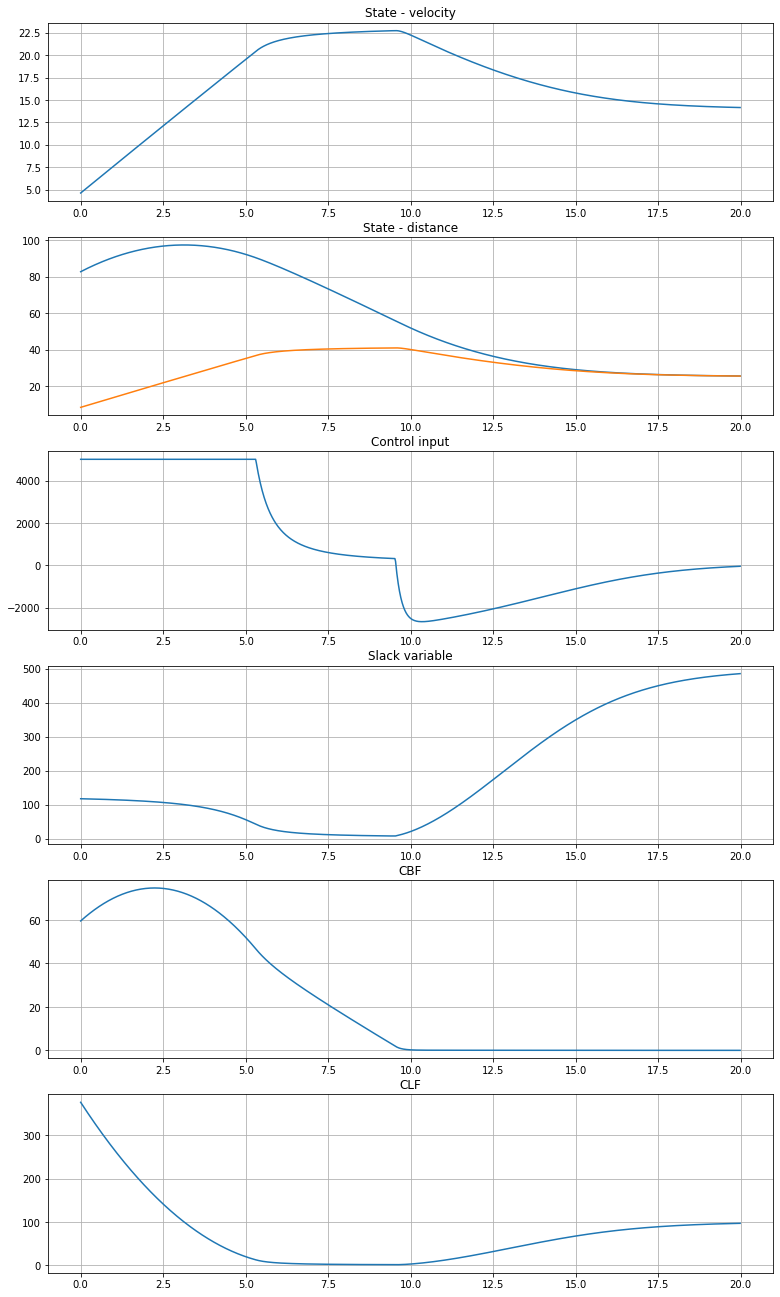

In [10]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 20, dt)

ax[0].plot(t_lns, np.array(x_lst)[0,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[0,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[0,:,1])

ax[2].plot(t_lns, np.array(u_lst)[0,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[0,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[0,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[0,:])
ax[5].grid(True)
ax[5].set_title('CLF')

### First time

Text(0.5, 1.0, 'CLF')

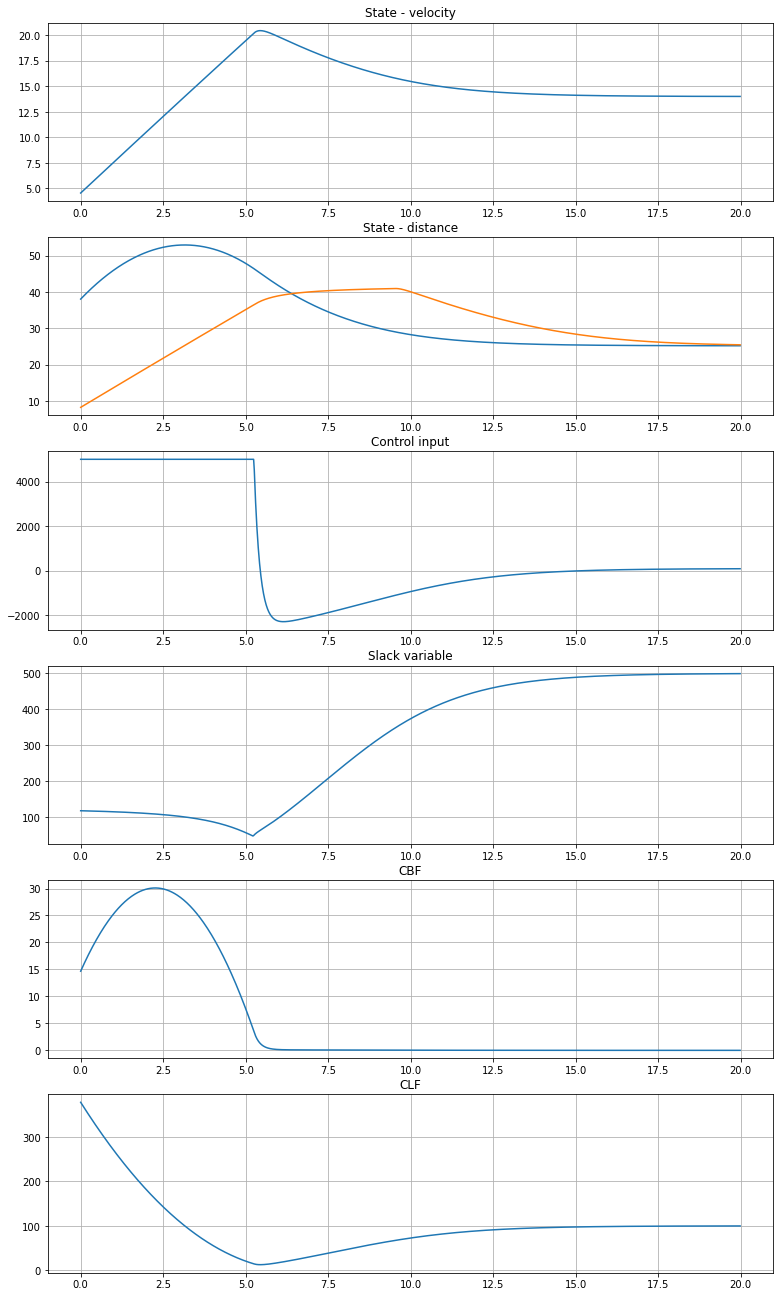

In [12]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 20, dt)

exp = 19

ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[0,:,1])

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')